<h3> Extracting protein sequences' features using ProtBert-BFD pretrained-model <h3>

<b>1. Load necessry libraries including huggingface transformers<b>

In [1]:
!pip install -q transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 6.5 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 28.0 MB/s 


In [2]:
import torch
from transformers import BertModel, BertTokenizer
import re
import os
import requests
from tqdm.auto import tqdm
import pickle 
import numpy as np 
import sys

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# drive.flush_and_unmount()

In [3]:
!pwd

%ls drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/

/content
parsed_tab_for_embed.pkl


<b>2. Load the vocabulary and ProtBert-BFD Model</b>

In [4]:
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd', do_lower_case=False )

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

In [5]:
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<b>3. Load the model into the GPU if avilabile and switch to inference mode<b>

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
model = model.to(device)
model = model.eval()

<b>4. Create or load sequences and map rarely occured amino acids (U,Z,O,B) to (X)<b>

In [ ]:
!pwd
%ls

/content
drive/  sample_data/


In [9]:
# with open("parsed_tab_for_embed.pkl", 'rb') as f:
with open("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/parsed_tab_for_embed.pkl", 'rb') as f:
  full_tab_for_embed = pickle.load(f)
print(full_tab_for_embed)


          code  nsub  QSBIO_err_prob  best_BU  homo pdb_code  \
163180  5ahz_1   3.0             0.0      1.0   1.0     5ahz   
102644  3q6m_1   6.0             0.0      1.0   1.0     3q6m   
16398   1luq_1   4.0             0.0      1.0   1.0     1luq   
108576  3t6f_1   4.0             0.0      1.0   1.0     3t6f   
26678   1srf_1   4.0             0.0      1.0   1.0     1srf   
...        ...   ...             ...      ...   ...      ...   
161880  4zt1_1   2.0            14.3      1.0   1.0     4zt1   
117840  4a56_1   2.0            14.3      1.0   1.0     4a56   
174177  5hap_1   2.0            14.3      1.0   1.0     5hap   
152497  4s2l_1   2.0            14.3      1.0   1.0     4s2l   
171148  5faq_1   2.0            14.3      1.0   1.0     5faq   

                                                    fasta  
163180  A A A V R E N A L L S S S L W V N V A L A G I ...  
102644  A A T K P I W T R N P D D I T N E E Y G E F Y ...  
16398   A E A G I T G T W Y N Q L G S T F I V T A G

In [10]:
full_tab_for_embed.shape

(31994, 7)

In [11]:
# We did this step in the previous notebook, leaving here for the param name  
tab_for_embed = full_tab_for_embed[full_tab_for_embed['fasta'].notnull()]
tab_for_embed.shape

(31994, 7)

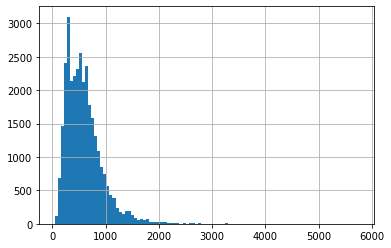

In [12]:
fas_len = tab_for_embed.fasta.apply(len)
# fas_len[fas_len>=1000].hist(bins=100)
# fas_len.hist(bins=100, range=[0, 2000])
fas_len.hist(bins=100)

In [ ]:
# was needed to reduce size due to padding
# stopped padding (embedding singularly and not in batch) so not using this filter

# tab_for_embed = tab_for_embed.loc[fas_len[fas_len<2100].index]

save this table as a pkl for label use and so on

In [13]:
# %cd drive/MyDrive/OrlyPred/Homomer_embeds/results
# !pwd
with open(("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/tab_for_embed.pkl"), 'wb') as f:
      pickle.dump(tab_for_embed, f)

In [14]:
!pwd
!ls drive/MyDrive/OrlyPred/Homomer_embeds/results

/content
embeds_Mar_22


In [15]:
tab_for_embed.fasta.head().values.astype(str)

array(['A A A V R E N A L L S S S L W V N V A L A G I A I L V F V Y M G R T I R P G R P R L I W G A T L M I P L V S I S S Y L G L L S G L T V G M I E M P A G H A L A G E M V R S Q W G R Y L T W A L S T P M I L L A L G L L A D V D L G S L F T V I A A D I G M C V T G L A A A M T T S A L L F R W A F Y A I S C A F F V V V L S A L V T D W A A S A S S A G T A E I F D T L R V L T V V L W L G Y P I V W A V G V E G L A L V Q S V G V T S W A Y S V L D V F A K Y V F A F I L L R W V A N N E R T V A V A G Q T L G T M S S D D H H H H H H',
       'A A T K P I W T R N P D D I T N E E Y G E F Y K S L T N D W E D H L A V K H F S V E G Q L E F R A L L F V P R R A P F D L F E N R K K K N N I K L Y V R R V F I M D N C E E L I P E Y L N F I R G V V D S E D L P L N I S R E M L Q Q S K I L K V I R K N L V K K C L E L F T E L A E D K E N Y K K F Y E Q F S K N I K L G I H E D S Q N R K K L S E L L R Y Y T S A S G D E M V S L K D Y C T R M K E N Q K H I Y Y I T G E T K D Q V A N S A F V E R L R K H G L E V I Y 

In [16]:
# replace UZOB tokens for X in all the sequences 
embedding_list = list(tab_for_embed.fasta.values.astype(str))
pbar = tqdm(embedding_list)
clean_embed_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in pbar]


  0%|          | 0/31994 [00:00<?, ?it/s]

In [17]:
# find the length of longest fasta (and omit spaces from the count)
max_length_seq = max(len(x)-x.count(' ') for x in clean_embed_list)
print(max_length_seq)


2880


<b>5. Tokenize, encode sequences and load it into the GPU if possibile<b>

In [ ]:
# this step has to happen in iterations because ram is not large enough to hold the whole thing
# but, when tokenizing, for each batch the amount of padding is determined by the longest 
# hence, need to set max_length by the longest sequence in data (in addition to pad_to_max_length)

#ids = tokenizer.batch_encode_plus(clean_embed_list[0:2], add_special_tokens=True, pad_to_max_length=True,max_length=max_length_seq)

In [18]:
torch.cuda.empty_cache()
model = model.to(device)
model = model.eval()


In [19]:
drive.mount("/content/drive")
%pwd
%ls drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/
# %cd drive/MyDrive/OrlyPred/Homomer_embeds/results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
parsed_tab_for_embed.pkl  tab_for_embed.pkl


In [ ]:

 # print(range(50000,len(clean_embed_list)))
# for i in range(50000,len(clean_embed_list)):
#   print(i)

**If we avg on the embed vec before appending it, we will save lots of ram. so this should be the next step **

In [20]:
# CLS id =2, SEP id =3, PAD id = 0
torch.set_printoptions(edgeitems=45)
inference_embed_list = list()
final_embed = np.zeros((1,1024))

attention_list = list()
input_ids_list = list()
for i in range(len(clean_embed_list)):
  if((i % 1000)==0):
    print(i)  
## used for checking the embeddings - run only first rows
# for i in range(len(clean_embed_list[:5])):
#   print(i)  

  ids = tokenizer.batch_encode_plus([clean_embed_list[i]], add_special_tokens=True, 
                                    pad_to_max_length=False)
  input_ids = torch.tensor(ids['input_ids']).cuda()
  # input_ids_list.append(input_ids)
  
  # print("input ids")
  # print(input_ids)
  # print(input_ids.shape)
  attention_mask = torch.tensor(ids['attention_mask']).cuda()
  # print("attention mask")
  # print(attention_mask)

  with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)[0]
    embedding = embedding.cpu().numpy()

  # remove CLS, SEP, tokens 
  # print((embedding.shape))
  bol_mask=[True]*embedding.shape[1]
  bol_mask[0]=False
  bol_mask[-1]=False
  clean_embed = embedding[0][bol_mask]
  # print(clean_embed)
  # print(clean_embed.shape)

  embed_mean = np.mean(clean_embed, axis =0)
  # print(embed_mean.shape)
  #inference_embed_list.append(embed_mean)
  final_embed = np.concatenate((final_embed, embed_mean.reshape((1,1024))),axis=0)

  # if ((i % 10000)==0):
  #   with open(("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Jan_22/embed_pkl_"+str(i)), 'wb') as f:
  #     pickle.dump(final_embed, f)

# end of for 
with open(("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Mar_22/embed_pkl_final_all"), 'wb') as f:
    pickle.dump(final_embed, f)
# with open(("drive/MyDrive/OrlyPred/Homomer_embeds/results/embeds_Jan_22/embed_pkl_check_2"), 'wb') as f:
#     pickle.dump(final_embed, f)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [ ]:

# print(final_embed.shape)
# print(final_embed)

In [ ]:
# print(clean_embed_list[0])
t = tokenizer.decode(input_ids[0])
p = t=="[CLS]"
print(t[0:3])

UMAP DRAFT - full part is in a different notebook

In [ ]:
import umap

In [ ]:
!ls drive/MyDrive/OrlyPred/Data/final_embed_pkls/


In [ ]:
with open("drive/MyDrive/OrlyPred/Data/final_embed_pkls/embed_pkl_50000","rb") as f:
    npy_embed_50k = pickle.load(f)


In [ ]:
reducer = umap.UMAP(verbose=True)
umap_embeds = reducer.fit_transform(npy_embed_50k)
umap_embeds.shape

In [ ]:
tab_test = tab_for_embed.head(50000)
# print(tab_test)
print(len(tab_test.nsubunits))
t= umap_embeds[0:50000,]
t.shape

In [ ]:
print (len(sns.color_palette(n_colors=64)))

for x in tab_test.nsubunits:
  print (sns.color_palette(n_colors=64)[int(x)])
  # print(int(x))

In [ ]:
c_palette=sns.color_palette(n_colors=64)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(
    t[:, 0],
    t[:, 1],
    c=[c_palette[int(x)] for x in tab_test.nsubunits])